In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import os
import selenium
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from bs4 import BeautifulSoup
import time

In [2]:
SDB = sqlite3.connect('autopliusvisi.db') # jei neegsiztuoja - bus sukurfta nauja sqlite DB
Cs = SDB.cursor()

sql="""SELECT * FROM T1;"""
Cs.execute(sql)
ans = Cs.fetchall()
gamintojas, modelis, kaina, metai, kebulas, kuras, pavaros, galingumas, rida, nuorodos, pirmaregistracija, technikine = list(map(list, zip(*ans)))

df = pd.read_sql_query(sql, con=SDB)
df.head(3)

,gamintojas,modelis,kaina,metai,kebulas,kuras,pavaros,galingumas,rida,nuorodos,pirmaregistracija,technikine
0,-Kita-,-kita-,1750.0,2008.0,Krovininis mikroautobusas,Dyzelinas,Mechaninė,None,NaN,https://autoplius.lt/skelbimai/kita-kita-krovi...,None,None
1,-Kita-,-kita-,3900.0,2011.0,Sedanas,Elektra,None,None,10.0,https://autoplius.lt/skelbimai/kita-kita-sedan...,None,None
2,-Kita-,-kita-,6800.0,2020.0,Hečbekas,Elektra,None,29,14000.0,https://autoplius.lt/skelbimai/kita-kita-hecbe...,None,2025-03


In [4]:
# Įvertinkite automobilių kainos priklausomybes nuo ridos, amžiaus, variklio galios, kėbulo ti-
# po, pavarų dėžės tipo

In [3]:
df['amzius']=2024-df['metai']

df['ridosintervalai'] = np.ceil(df['rida'] / 20000) * 20000

df.head()

,gamintojas,modelis,kaina,metai,kebulas,kuras,pavaros,galingumas,rida,nuorodos,pirmaregistracija,technikine,amzius,ridosintervalai
0,-Kita-,-kita-,1750.0,2008.0,Krovininis mikroautobusas,Dyzelinas,Mechaninė,None,NaN,https://autoplius.lt/skelbimai/kita-kita-krovi...,None,None,16.0,NaN
1,-Kita-,-kita-,3900.0,2011.0,Sedanas,Elektra,None,None,10.0,https://autoplius.lt/skelbimai/kita-kita-sedan...,None,None,13.0,20000.0
2,-Kita-,-kita-,6800.0,2020.0,Hečbekas,Elektra,None,29,14000.0,https://autoplius.lt/skelbimai/kita-kita-hecbe...,None,2025-03,4.0,20000.0
3,-Kita-,-kita-,60500.0,2024.0,Krovininis mikroautobusas,Elektra,None,66,NaN,https://autoplius.lt/skelbimai/kita-kita-41-kw...,None,None,0.0,NaN
4,Abarth,124 Spider,18900.0,2017.0,Kabrioletas,Benzinas,Mechaninė,125,75000.0,https://autoplius.lt/skelbimai/abarth-124-spid...,JAV,2027-03,7.0,80000.0


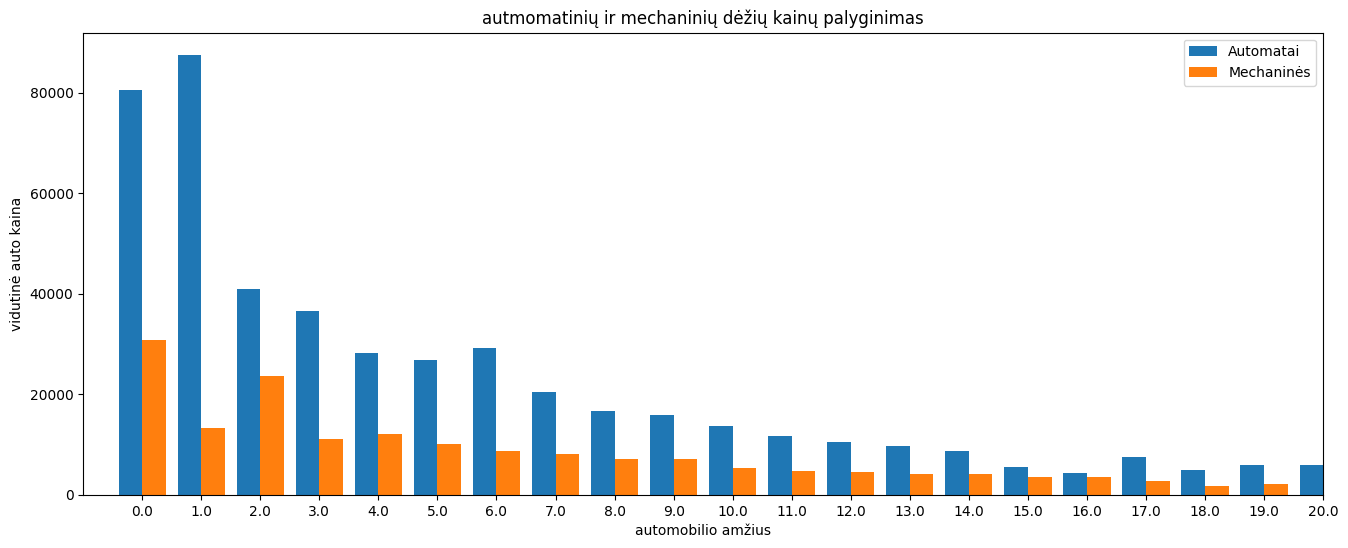

In [4]:
dfA=df[df['pavaros']=='Automatinė']
dfM=df[df['pavaros']=='Mechaninė']
dfgA = dfA[['amzius', 'kaina']].groupby('amzius').mean(numeric_only=True).reset_index()
dfgM = dfM[['amzius', 'kaina']].groupby('amzius').mean(numeric_only=True).reset_index()

fig, axis = plt.subplots(figsize=[16, 6])
x = dfgA['amzius']
x2=dfgM['amzius']
w = 0.4
i = axis.bar(x-w/2,dfgA['kaina'], label='Automatai', width=w)
o = axis.bar(x2+w/2, dfgM['kaina'], label='Mechaninės', width=w)

axis.set_xticks(x)
axis.set_xticklabels(dfgA['amzius'])
axis.set_xlim(left=min(x) - 1, right=20)
axis.legend(loc='best')
axis.set_xlabel('automobilio amžius')
axis.set_ylabel('vidutinė auto kaina')
plt.title('autmomatinių ir mechaninių dėžių kainų palyginimas')
plt.show()

In [5]:
dfrida = df.groupby('ridosintervalai')['kaina'].mean().reset_index()

# Optionally, rename the columns for clarity
dfrida.columns = ['ridosintervalai', 'vidutinekaina']
dfrida['vidutinekaina']=round(dfrida['vidutinekaina'], 0)

dfrida.head()

,ridosintervalai,vidutinekaina
0,20000.0,48030.0
1,40000.0,39388.0
2,60000.0,35662.0
3,80000.0,24808.0
4,100000.0,20737.0


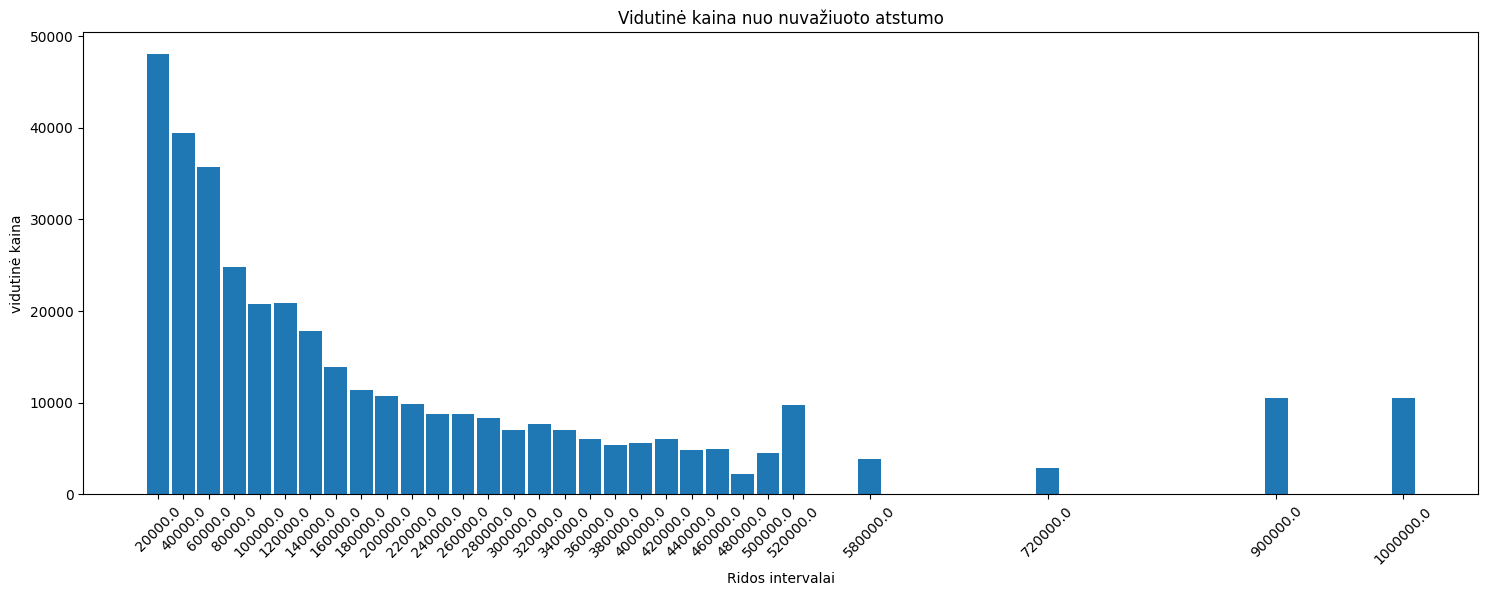

In [6]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfrida['ridosintervalai'], dfrida['vidutinekaina'], width=18000)
axis.set_xticks(dfrida['ridosintervalai'])
axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('Ridos intervalai')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina nuo nuvažiuoto atstumo')

# plt.tight_layout()
plt.show()

In [7]:
dfamzius = df.groupby('amzius')['kaina'].mean().reset_index()

dfamzius['kaina']=round(dfamzius['kaina'], 0)

dfamzius.head()

,amzius,kaina
0,0.0,55877.0
1,1.0,56635.0
2,2.0,34570.0
3,3.0,31777.0
4,4.0,24810.0


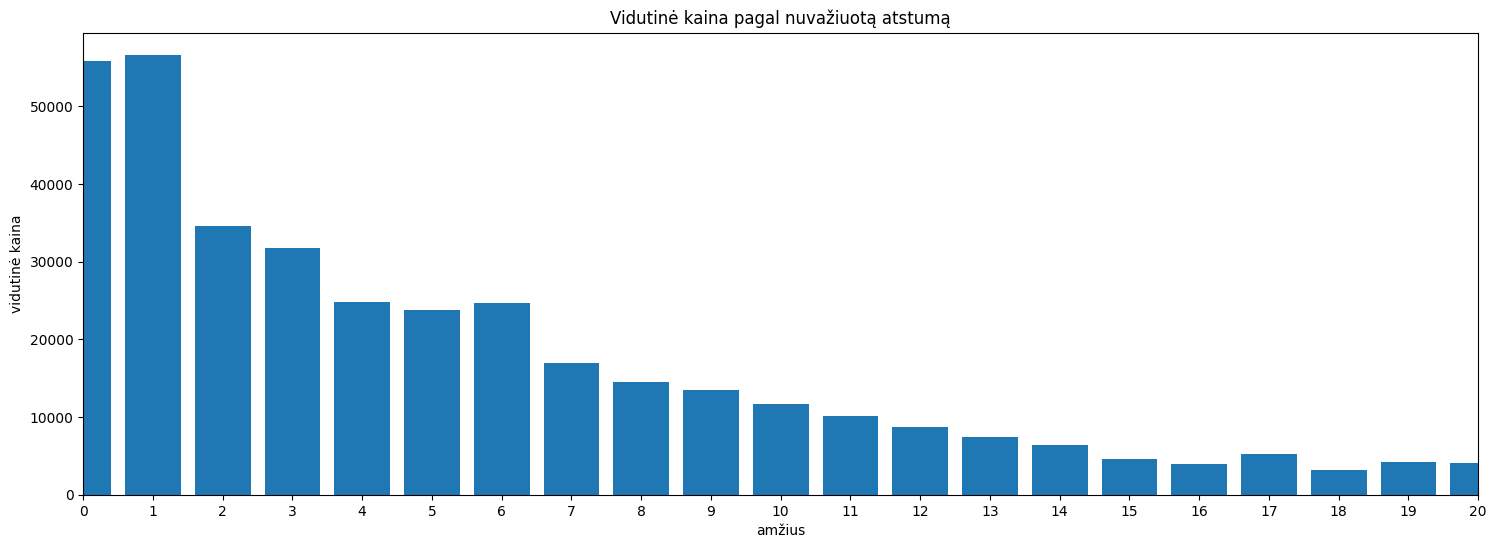

In [8]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfamzius['amzius'], dfamzius['kaina'])
axis.set_xticks(dfamzius['amzius'])
axis.set_xlabel('amžius')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal nuvažiuotą atstumą')
axis.set_xlim(left=0, right=20)

# plt.tight_layout()
plt.show()

In [9]:
dfkw = df.groupby('galingumas')['kaina'].mean().reset_index()

dfkw['kaina']=round(dfkw['kaina'], 0)

dfkw.head()

,galingumas,kaina
0,100,9756.0
1,101,13300.0
2,103,7650.0
3,104,3633.0
4,105,7106.0


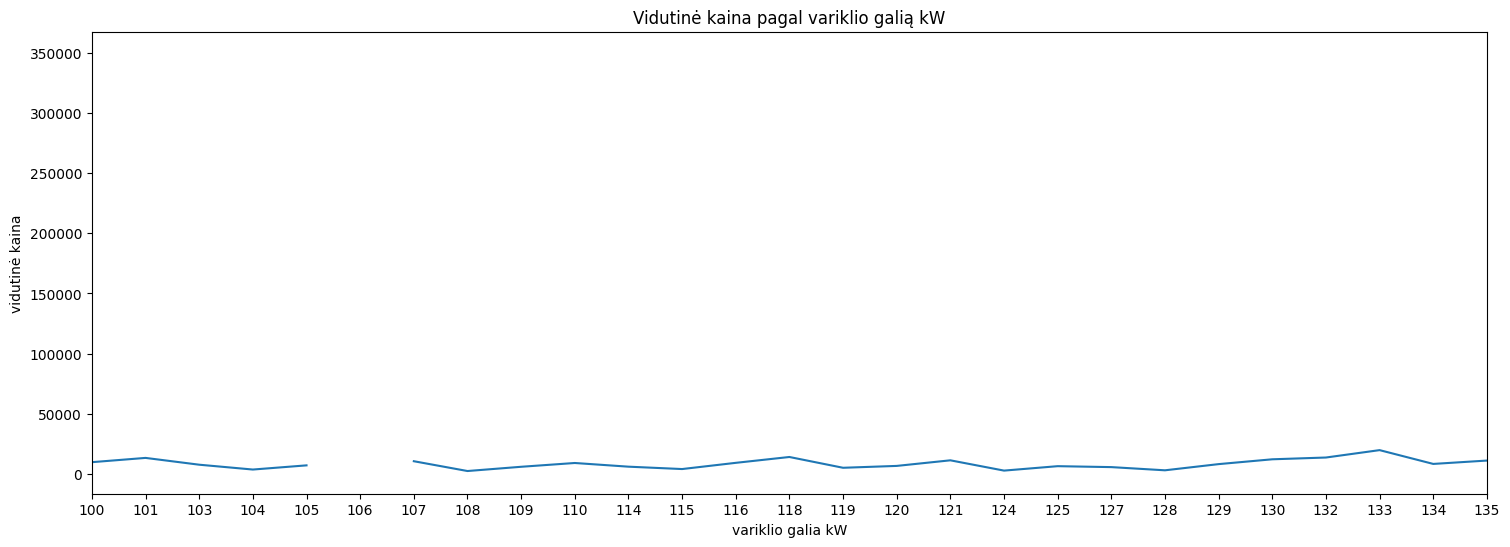

In [10]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.plot(dfkw['galingumas'], dfkw['kaina'])
axis.set_xticks(dfkw['galingumas'])
axis.set_xlabel('variklio galia kW')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal variklio galią kW')
axis.set_xlim(left=0, right=26)

# plt.tight_layout()
plt.show()

In [11]:
dfkebulas = df.groupby('kebulas')['kaina'].mean().reset_index()

dfkebulas['kaina']=round(dfkebulas['kaina'], 0)

dfkebulas.head()

,kebulas,kaina
0,Hečbekas,8621.0
1,Kabrioletas,24883.0
2,Keleivinis mikroautobusas,10335.0
3,Kita,7500.0
4,Komercinis,6697.0


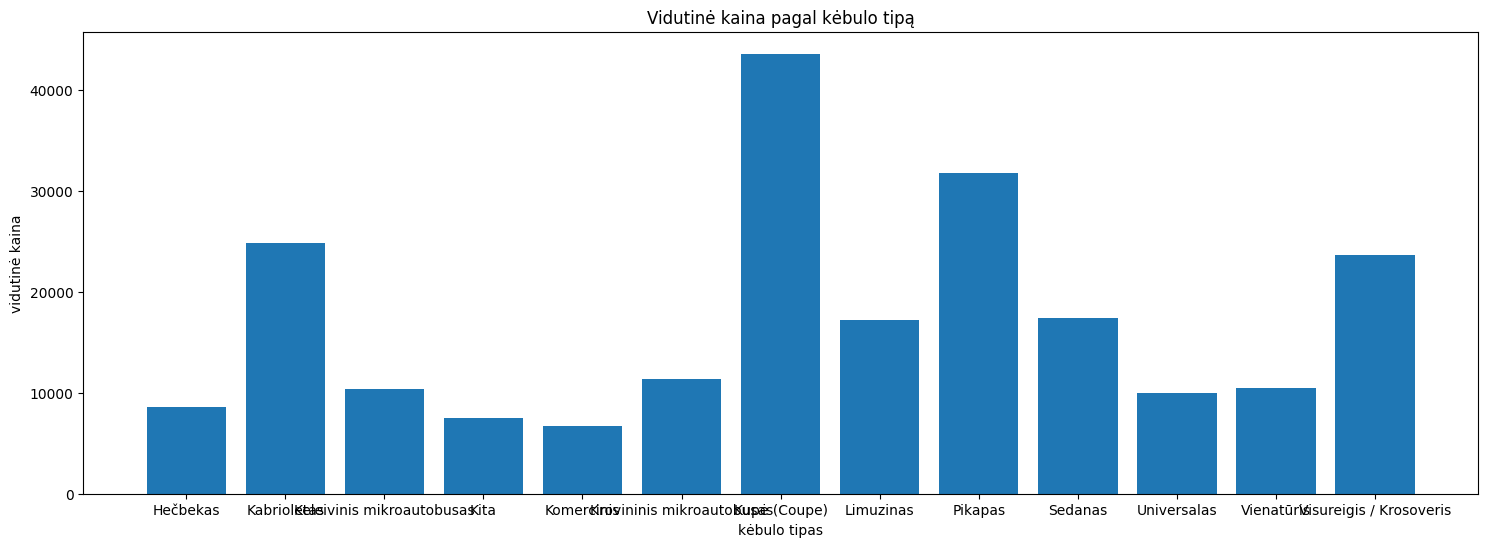

In [12]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfkebulas['kebulas'], dfkebulas['kaina'])
axis.set_xticks(dfkebulas['kebulas'])
axis.set_xlabel('kėbulo tipas')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal kėbulo tipą')


# plt.tight_layout()
plt.show()

In [98]:
# Įvertinkite, ar kainos dydžiui turi įtaką pardavėjo miestas/rajonas? Ko-
# kios šalys vyrauja kaip pirmos registracijos šalis? Ar dėl to yra kokia nors įtaka kainoms?
# Kiek skelbimų nurodo galiojančią TA? Ar TA turėjimas ir TA galiojimo trukmė turi įtaką
# kainų lygiui?

In [13]:
pirmasaliskiekis = df['pirmaregistracija'].value_counts()

pirmasaliskiekis.head()

pirmaregistracija
JAV           322
Vokietija     317
Lietuva       171
Prancūzija    157
Olandija       75
Name: count, dtype: int64

In [14]:
dfpirmasaliskainos = df.groupby('pirmaregistracija')['kaina'].mean().reset_index()

dfpirmasaliskainos['kaina']=round(dfpirmasaliskainos['kaina'], 0)
dfpirmasaliskainos=dfpirmasaliskainos.sort_values(by='kaina', ascending=False)
dfpirmasaliskainos.head()

,pirmaregistracija,kaina
11,Latvija,38295.0
13,Lietuva,29266.0
10,Kanada,25393.0
21,Švedija,24082.0
12,Lenkija,21500.0


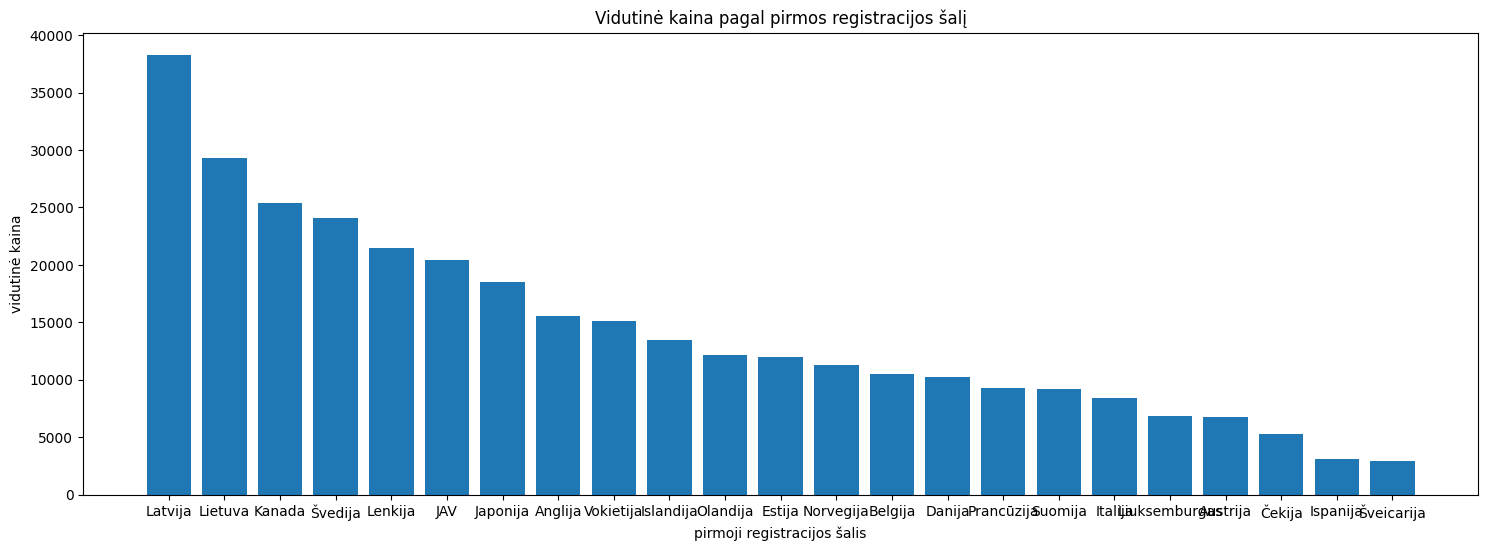

In [15]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfpirmasaliskainos['pirmaregistracija'], dfpirmasaliskainos['kaina'])
axis.set_xticks(dfpirmasaliskainos['pirmaregistracija'])
axis.set_xlabel('pirmoji registracijos šalis')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal pirmos registracijos šalį')


# plt.tight_layout()
plt.show()

In [16]:
df['technikine'] = pd.to_datetime(df['technikine'], errors='coerce')
df.head()

,gamintojas,modelis,kaina,metai,kebulas,kuras,pavaros,galingumas,rida,nuorodos,pirmaregistracija,technikine,amzius,ridosintervalai
0,-Kita-,-kita-,1750.0,2008.0,Krovininis mikroautobusas,Dyzelinas,Mechaninė,None,NaN,https://autoplius.lt/skelbimai/kita-kita-krovi...,None,NaT,16.0,NaN
1,-Kita-,-kita-,3900.0,2011.0,Sedanas,Elektra,None,None,10.0,https://autoplius.lt/skelbimai/kita-kita-sedan...,None,NaT,13.0,20000.0
2,-Kita-,-kita-,6800.0,2020.0,Hečbekas,Elektra,None,29,14000.0,https://autoplius.lt/skelbimai/kita-kita-hecbe...,None,2025-03-01,4.0,20000.0
3,-Kita-,-kita-,60500.0,2024.0,Krovininis mikroautobusas,Elektra,None,66,NaN,https://autoplius.lt/skelbimai/kita-kita-41-kw...,None,NaT,0.0,NaN
4,Abarth,124 Spider,18900.0,2017.0,Kabrioletas,Benzinas,Mechaninė,125,75000.0,https://autoplius.lt/skelbimai/abarth-124-spid...,JAV,2027-03-01,7.0,80000.0


In [18]:
galiojanciostechnikines = 0
galiojatechkaina=0
negaliojanciostechnikines=0
negaliojatechkaina=0

for i in range(len(df)):
    
    if pd.isna(df.iloc[i]['technikine']) or df.iloc[i]['technikine'] < pd.to_datetime('2024-10-10'):
        negaliojanciostechnikines += 1
        negaliojatechkaina += df.iloc[i]['kaina']
    else:
        galiojanciostechnikines += 1
        galiojatechkaina += df.iloc[i]['kaina']
        
print(f'auto su galiojančia TA {galiojanciostechnikines} jų vid kaina yra {round(galiojatechkaina/galiojanciostechnikines, 0)}')
print(f'auto su negaliojančia TA {negaliojanciostechnikines} jų vid kaina yra {round(negaliojatechkaina/negaliojanciostechnikines, 0)}')
    

auto su galiojančia TA 1245 jų vid kaina yra nan
auto su negaliojančia TA 1273 jų vid kaina yra nan


In [19]:
populiariausiauto = df['gamintojas'].value_counts()
top10=populiariausiauto.head(10).index.tolist()
dfpopgamintojai = df[df['gamintojas'].isin(top10)]

print('populiariausi gamintojai')
print(populiariausiauto.head(10))

populiariausi gamintojai
gamintojas
Audi          400
Citroen       400
BMW           400
Dodge         310
Chrysler      273
Fiat          236
Dacia         125
Alfa Romeo    121
Cadillac       51
Bentley        49
Name: count, dtype: int64


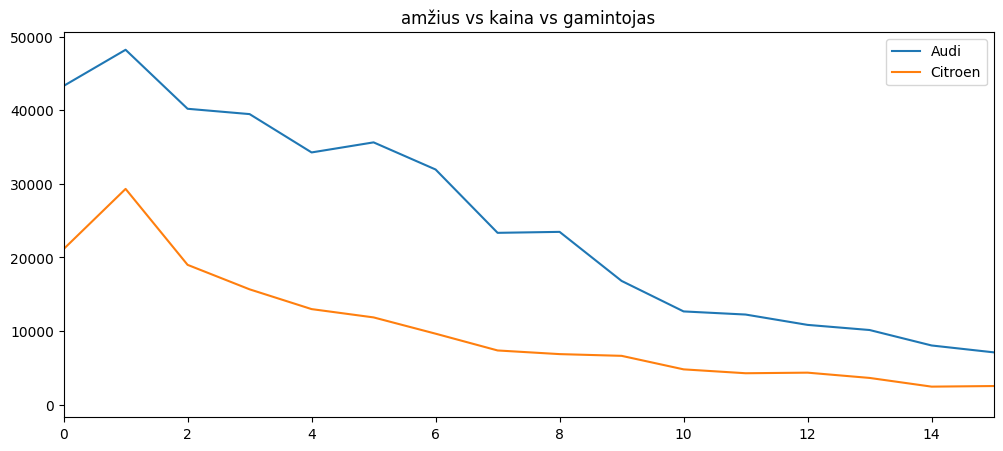

In [21]:
dfgamintojasamziuskaina=dfpopgamintojai.groupby(['gamintojas', 'amzius'])['kaina'].mean().reset_index()
dfgamintojasamziuskaina.head()

fig, axis = plt.subplots(figsize=(12, 5)) 
for i in range(2): 
    df11=dfgamintojasamziuskaina[dfgamintojasamziuskaina['gamintojas'] == top10[i]]
    axis.plot(df11['amzius'], df11['kaina'], label = top10[i])
    
# axis.set_xticks(datos)
axis.legend(loc='best')
plt.title('amžius vs kaina vs gamintojas')
axis.set_xlim(left=0, right=15)
# plt.xticks(rotation=90)
plt.show()

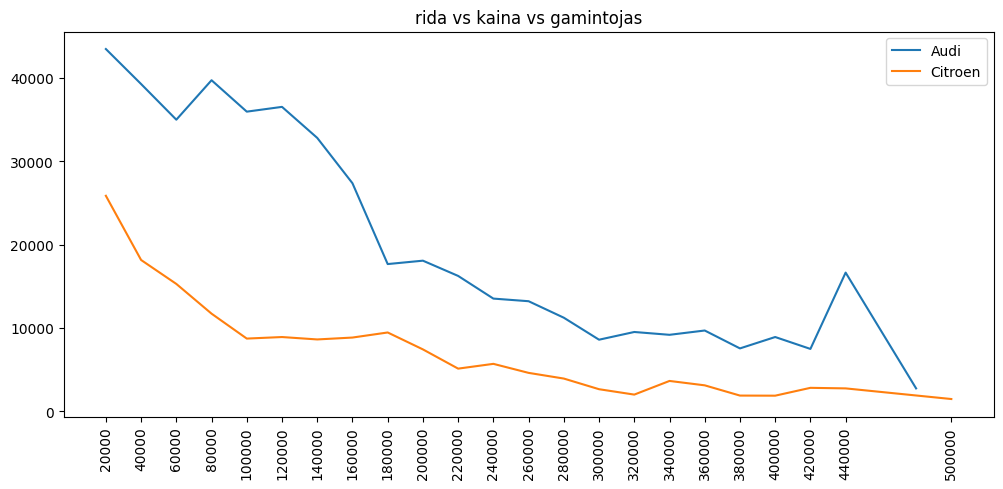

In [22]:
dfgamintojasridakaina=dfpopgamintojai.groupby(['gamintojas', 'ridosintervalai'])['kaina'].mean().reset_index()
dfgamintojasridakaina.head()

fig, axis = plt.subplots(figsize=(12, 5)) 
for i in range(2): 
    df11=dfgamintojasridakaina[dfgamintojasridakaina['gamintojas'] == top10[i]]
    axis.plot(df11['ridosintervalai'], df11['kaina'], label = top10[i])
    
axis.set_xticks(df11['ridosintervalai'])
axis.legend(loc='best')
plt.title('rida vs kaina vs gamintojas')
# axis.set_xlim(left=0, right=15)
plt.xticks(rotation=90)
plt.show()


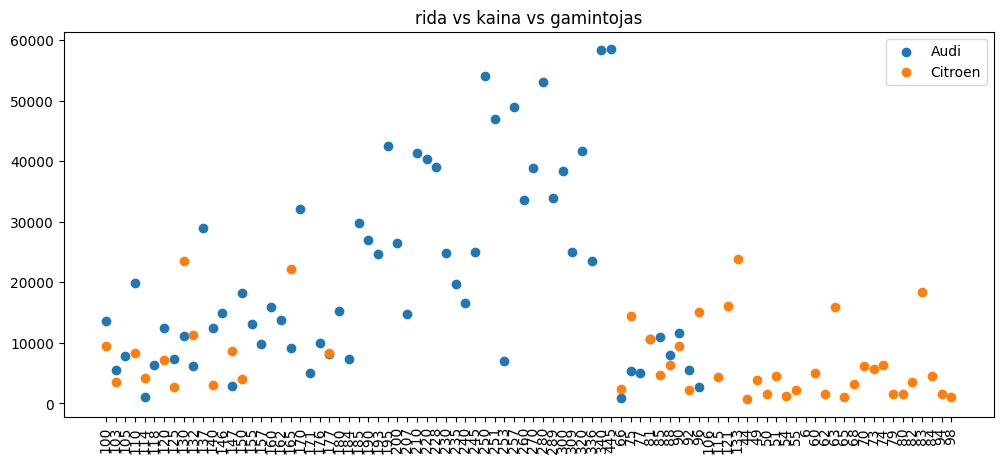

In [23]:
dfgamintojasgaliakaina=dfpopgamintojai.groupby(['gamintojas', 'galingumas'])['kaina'].mean().reset_index()
dfgamintojasgaliakaina.head()

dfgamintojasgaliakaina = dfgamintojasgaliakaina.sort_values(by='galingumas')

fig, axis = plt.subplots(figsize=(12, 5)) 
for i in range(2): 
    df11=dfgamintojasgaliakaina[dfgamintojasgaliakaina['gamintojas'] == top10[i]]
    df11.sort_values(by='galingumas')
    axis.scatter(df11['galingumas'], df11['kaina'], label = top10[i])
    
# axis.set_xticks(df11['ridosintervalai'])
axis.legend(loc='best')
plt.title('rida vs kaina vs gamintojas')
# axis.set_xlim(left=0, right=15)
plt.xticks(rotation=90)
plt.show()

In [34]:
df11

,gamintojas,galingumas,kaina
70,Volkswagen,100,4800.0
71,Volkswagen,103,4275.0
72,Volkswagen,110,15287.5
73,Volkswagen,140,10925.0
74,Volkswagen,147,9350.0
75,Volkswagen,176,12750.0
76,Volkswagen,180,15500.0
77,Volkswagen,203,33700.0
78,Volkswagen,250,12000.0
79,Volkswagen,44,750.0


In [ ]:
# Pateikite 10 populiariausių gamintojų variklio galių (kW), ridų, amžiaus, rinkoje esančių
# modelių kiekio vienetais pasiskirstymą (vidurkiai, medianos, kvartilės).

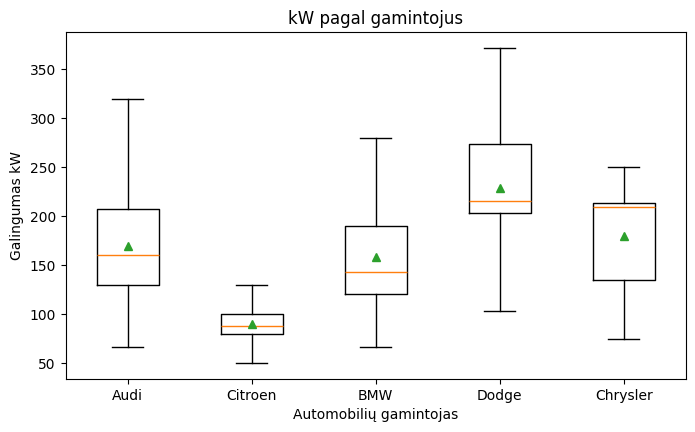

In [24]:
kwsarasai=[]

for i in range(5):
    kww=(df[df['gamintojas'] == top10[i]]['galingumas'].tolist()) 
    kww= [value for value in kww if value is not None]
    kww = [float(value) for value in kww]
    kwsarasai.append(kww)
    
fig, axis = plt.subplots(figsize=[8,4.5])
axis.boxplot(kwsarasai, showmeans=True, showfliers=False)
axis.set_xticklabels(top10[:5])
plt.title('kW pagal gamintojus')
plt.xlabel('Automobilių gamintojas')
plt.ylabel('Galingumas kW')
plt.show()

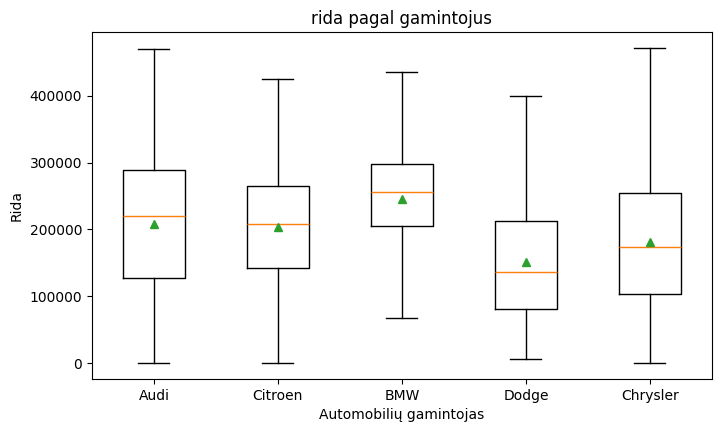

In [25]:
ridasarasai=[]

for i in range(5):
    rid=(df[df['gamintojas'] == top10[i]]['rida'].tolist()) 
    rid= [value for value in rid if value is not None]
    rid = [value for value in rid if pd.notna(value)]
    rid = [float(value) for value in rid]
    ridasarasai.append(rid)
    
fig, axis = plt.subplots(figsize=[8,4.5])
axis.boxplot(ridasarasai, showmeans=True, showfliers=False)
axis.set_xticklabels(top10[:5])
plt.title('rida pagal gamintojus')
plt.xlabel('Automobilių gamintojas')
plt.ylabel('Rida')
plt.show()

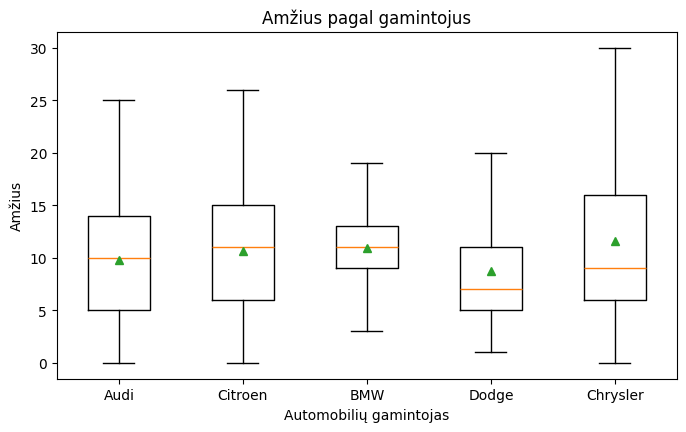

In [26]:
amziusarasai=[]

for i in range(5):
    amz=(df[df['gamintojas'] == top10[i]]['amzius'].tolist()) 
    amz= [value for value in amz if value is not None]
    amz = [value for value in amz if pd.notna(value)]
    amz = [float(value) for value in amz]
    amziusarasai.append(amz)
    
fig, axis = plt.subplots(figsize=[8,4.5])
axis.boxplot(amziusarasai, showmeans=True, showfliers=False)
axis.set_xticklabels(top10[:5])
plt.title('Amžius pagal gamintojus')
plt.xlabel('Automobilių gamintojas')
plt.ylabel('Amžius')
plt.show()